In [48]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [49]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/197787
Connected. Call `.close()` to terminate connection gracefully.


In [50]:
wine_df = pd.read_csv('winequalityN.csv', )
wine_df.columns = [c.strip().replace(' ', '_') for c in wine_df.columns]
wine_df.type[wine_df.type == 'white'] = 1
wine_df.type[wine_df.type == 'red'] = 0
wine_df["type"] = pd.to_numeric(wine_df["type"])
wine_df = wine_df.dropna()


wine_df.head()

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [51]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine dataset",
                                  labels=["quality"],
                                  query=query)

In [52]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (1.95s) 


RandomForestClassifier()

In [53]:
X_train

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,1,6.9,0.29,0.32,5.8,0.040,16.0,112.0,0.99300,3.04,0.58,11.2
1,1,7.4,0.28,0.25,11.9,0.053,25.0,148.0,0.99760,3.10,0.62,9.2
2,1,7.5,0.24,0.31,13.1,0.050,26.0,180.0,0.99884,3.05,0.53,9.1
3,1,6.7,0.22,0.33,1.2,0.036,36.0,86.0,0.99058,3.10,0.76,11.4
4,1,8.3,0.14,0.45,1.5,0.039,18.0,98.0,0.99215,3.02,0.56,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5289,1,7.9,0.16,0.30,4.8,0.037,37.0,171.0,0.99670,3.47,0.44,9.0
5291,1,6.7,0.24,0.37,11.3,0.043,64.0,173.0,0.99632,3.08,0.53,9.9
5292,1,6.0,0.27,0.19,1.7,0.020,24.0,110.0,0.98980,3.32,0.47,12.6
5293,1,6.8,0.33,0.31,7.4,0.045,34.0,143.0,0.99226,3.06,0.55,12.2


In [54]:
y_train

,quality
0,5
1,5
2,6
3,6
4,6
...,...
5289,4
5291,6
5292,7
5293,6


In [55]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [56]:
print(metrics)

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}, '4': {'precision': 0.42857142857142855, 'recall': 0.1, 'f1-score': 0.16216216216216217, 'support': 30}, '5': {'precision': 0.6054216867469879, 'recall': 0.5809248554913294, 'f1-score': 0.5929203539823009, 'support': 346}, '6': {'precision': 0.5256198347107438, 'recall': 0.6853448275862069, 'f1-score': 0.5949485500467726, 'support': 464}, '7': {'precision': 0.5357142857142857, 'recall': 0.32786885245901637, 'f1-score': 0.40677966101694907, 'support': 183}, '8': {'precision': 0.3333333333333333, 'recall': 0.034482758620689655, 'f1-score': 0.0625, 'support': 29}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'accuracy': 0.550519357884797, 'macro avg': {'precision': 0.34695150986811135, 'recall': 0.24694589916532034, 'f1-score': 0.2599015324583121, 'support': 1059}, 'weighted avg': {'precision': 0.5419480932292415, 'recall': 0.550519357884797, 'f1-score': 0.5309958569693533, 'support': 1059}}


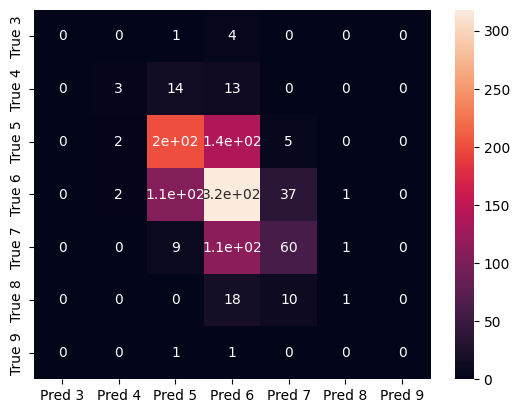

In [57]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True 3', 'True 4', 'True 5','True 6', 'True 7', 'True 8', 'True 9'],
                     ['Pred 3', 'Pred 4', 'Pred 5','Pred 6', 'Pred 7', 'Pred 8', 'Pred 9'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [58]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/197787/models/wine_model/1


Model(name: 'wine_model', version: 1)